In [1]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time


np.set_printoptions(precision=4, suppress = True)

/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

In [3]:
vae = VAE()
vae.set_weights('./vae/weights.h5')

In [4]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_files = np.load('./data/rnn_files.npz') 
rnn_input = rnn_files['rnn_input']
rnn_output = rnn_files['rnn_output']

initial_mu = np.load('./data/initial_z.npz')['initial_mu']
initial_log_var = np.load('./data/initial_z.npz')['initial_log_var']

In [5]:
rollout_files = np.load('./data/rollout/999206096.npz') 
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load('./data/series/999206096.npz') 
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']



In [6]:
print(reward_file[:50])
print(reward_2_file[:50])

[ 0.          6.77285223 -0.1        -0.1        -0.1        -0.1
 -0.1        -0.1        -0.1        -0.1        -0.1         3.33642612
 -0.1        -0.1        -0.1        -0.1        -0.1        -0.1
 -0.1        -0.1        -0.1        -0.1         3.33642612 -0.1
 -0.1        -0.1        -0.1        -0.1        -0.1        -0.1
  3.33642612 -0.1        -0.1        -0.1        -0.1        -0.1
  3.33642612 -0.1        -0.1        -0.1        -0.1        -0.1
 -0.1         3.33642612 -0.1        -0.1        -0.1        -0.1
 -0.1        -0.1       ]
[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [7]:
rnn_input[0,:,-1][:50]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])

In [8]:
rnn_output[0,:,-1][:50]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

array([ 0,  2,  4,  5,  6,  7, 10, 15, 24, 25, 27])

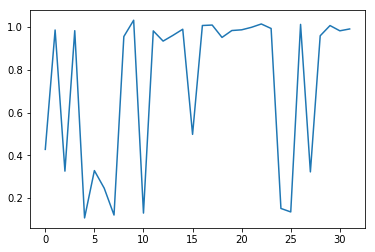

In [9]:
plt.plot(np.exp(initial_log_var[0]/2))
hot_zs = np.where(np.exp(initial_log_var[0]/2) < 0.9)[0]
hot_zs

In [236]:
rnn_input.shape

(100, 299, 36)

In [237]:
rnn_output.shape

(100, 299, 33)

In [238]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [239]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [240]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) 
    return z

In [241]:
np_random, seed = seeding.np_random()

In [242]:
rnn.forward.output_shape

[(None, None, 481), (None, 256), (None, 256)]

In [243]:
def sample_next_mdn_output(obs, h, c):
    
    d = GAUSSIAN_MIXTURES * Z_DIM

    out = rnn.forward.predict([np.array([[obs]]),np.array([h]),np.array([c])])
    
    y_pred = out[0][0][0]
    new_h = out[1][0]
    new_c = out[2][0]
    
    z_pred = y_pred[:3*d]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)
    
    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
    
    # adjust temperatures
    logmix2 = np.copy(log_pi)
    logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)

    for j in range(z_dim):
        idx = get_pi_idx(np_random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j,idx]
        chosen_log_sigma[j] = log_sigma[j,idx]
        
    next_z = sample_z(chosen_mu, chosen_log_sigma)

    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0

    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c

In [244]:
run_idx = 10

# real = obs_data[run_idx]
obs = rnn_input[run_idx]
actual = rnn_output[run_idx] 

print(obs.shape)
print(actual.shape)


(299, 36)
(299, 33)


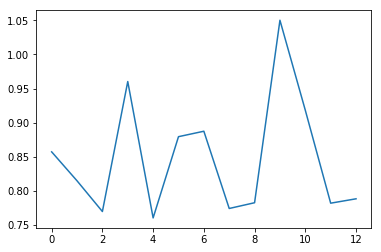

In [245]:
new_h = np.zeros(256)
new_c = np.zeros(256)
idx = 50
next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c = sample_next_mdn_output(obs[idx,:], new_h, new_c)
plt.plot(np.exp(chosen_log_sigma[hot_zs]))
# plt.plot(chosen_mu[hot_zs])

# plt.plot(actual[idx,hot_zs])


8.017189492881634
[[0.13897088]]
[2.4972675 2.4233747 3.1531115 2.9838307 3.243407 ]


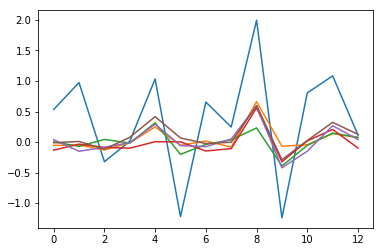

In [246]:
d = GAUSSIAN_MIXTURES * Z_DIM

print(sum(np.abs(obs[idx,hot_zs])))

plt.plot(actual[idx,hot_zs])


y_pred = rnn.model.predict(np.array([[obs[idx,:]]]))

# print(y_pred)

z_pred = y_pred[:,:,:(3*d)]
rew_pred = y_pred[:,:,-1]



print(rew_pred)

z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

log_pi, mu, log_sigma = np.split(z_pred, 3, 1)


plt.plot(mu[hot_zs])

log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

print(sum(np.abs(mu)))


In [247]:
current_z = obs[idx]
i = idx
current_h = np.zeros(256)
current_c = np.zeros(256)

KeyboardInterrupt: 

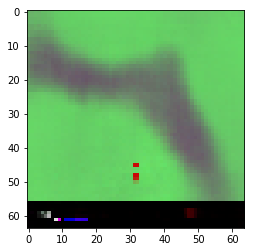

In [249]:

next_z = obs[idx,:]
next_h = np.zeros(256)
next_c = np.zeros(256)
# next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
# plt.imshow( next_z_decoded)
# plt.show()

for i in range(200):
#     print(np.array([[next_z]]).shape)
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)

    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
#     next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]


    next_z = np.concatenate([next_z, [1,1,0], [next_reward]])
    
    print(rew_pred)

#     plt.subplot(211)
    plt.gca().cla() 
    plt.imshow( next_z_decoded)
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
#     time.sleep(0.02) 

#     plt.subplot(221)
#     plt.imshow( next_mu_decoded)
#     plt.show()bbc
    # plt.imshow(next_z_decoded)
    # plt.show()

In [ ]:
hot_zs

(33, 299)


/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


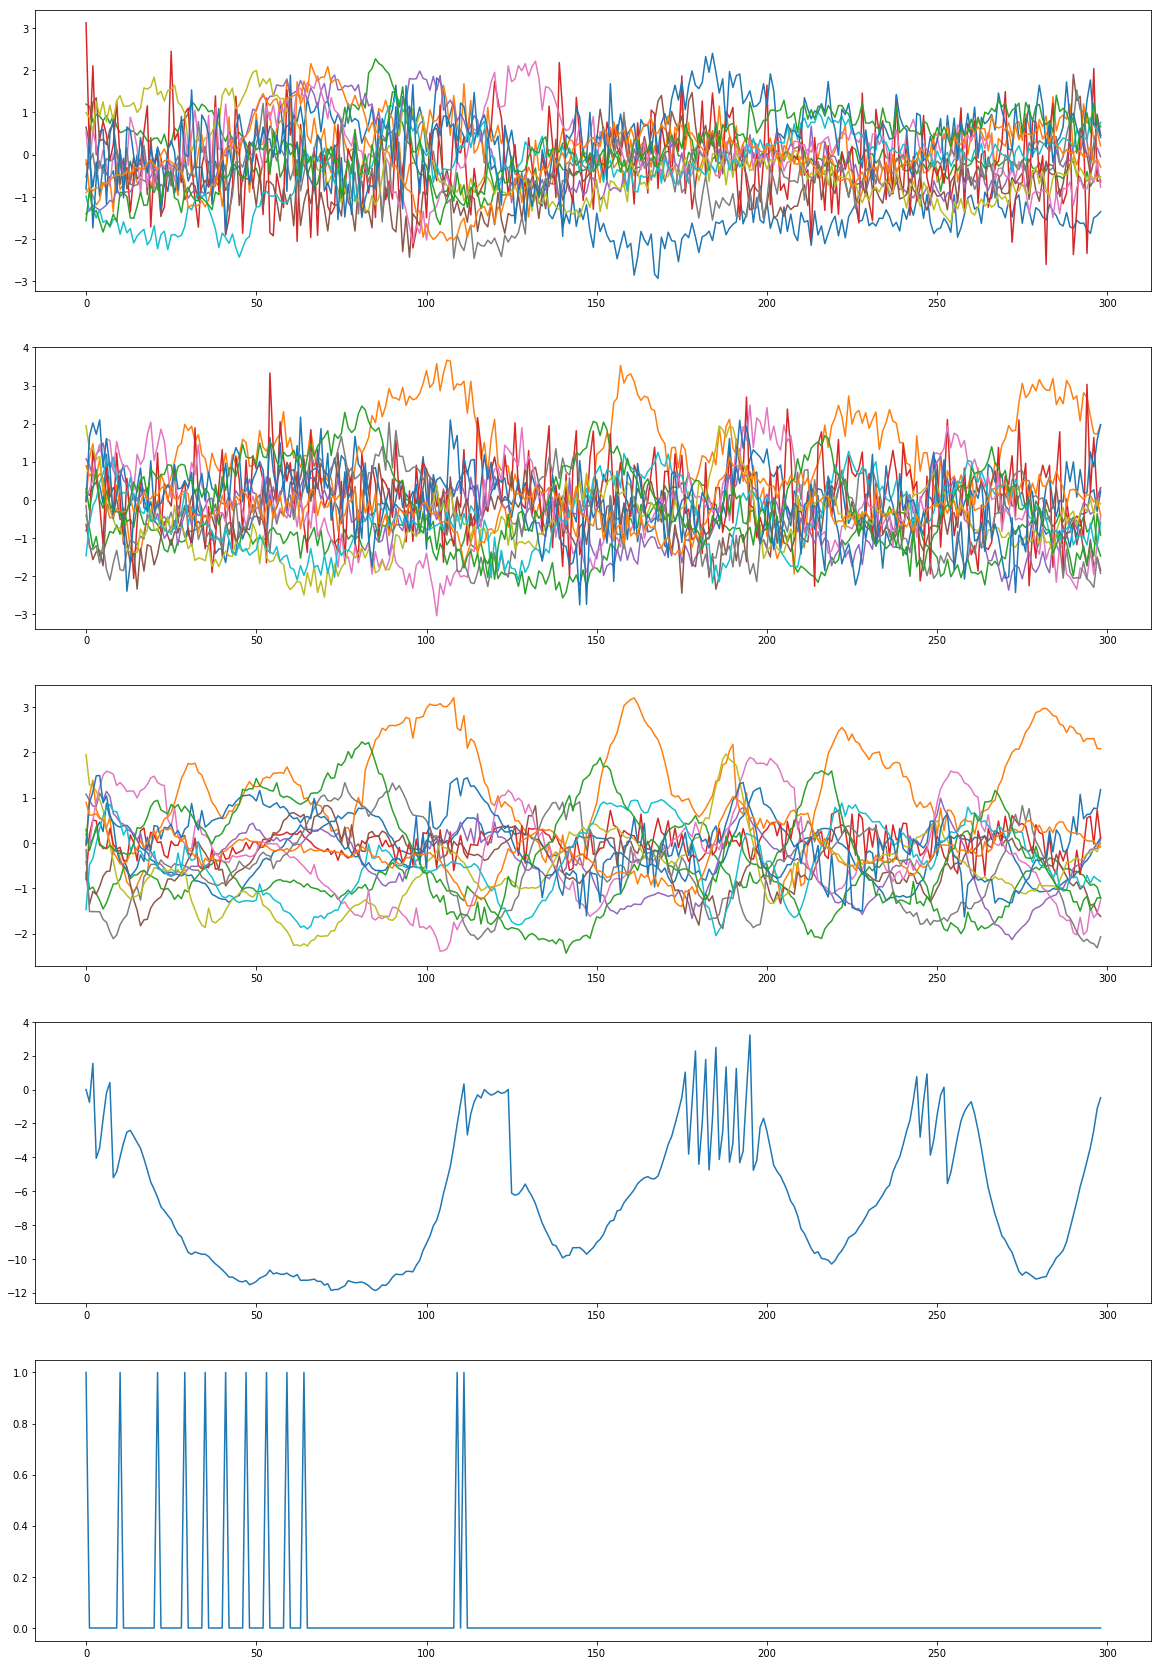

In [252]:
b = np.swapaxes(actual,0,1)
print(b.shape)
actual_rew = b[-1,:]

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
next_rews = np.zeros(shape = (1,299))
# next_z = np.copy(obs)
# print(next_z.shape)
next_z = obs[idx,:]

next_mus[:,0] = next_z[:32]
next_zs[:,0] = next_z[:32]
next_rews[:,0] = next_z[-1]

for i in range(1,299):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_rews[:,i] = rew_pred
    
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
#     plt.gca().cla() 
#     plt.imshow( next_z_decoded)
# #     plt.show()
#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 
    
    next_z = np.concatenate([next_z, [-1,1,0], [next_reward]])

plt.figure(figsize=(20,30))
for i in hot_zs:
    plt.subplot(511)
    plt.plot( b[i,:])
    plt.subplot(512)
    plt.plot( next_zs[i,:])
    plt.subplot(513)
    plt.plot( next_mus[i,:])
    
plt.subplot(514)
plt.plot(next_rews[0,:])

plt.subplot(515)
plt.plot(actual_rew[:])
    
# print(next_zs)
    